In [1]:
import pymc as pm
import numpy as np
import arviz as az
from itertools import combinations

%load_ext lab_black
%load_ext watermark

# Coagulation

An example of Bayesian ANOVA.

Adapted from [Unit 7: anovacoagulation.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit7/anovacoagulation.odc).

Associated lecture video: Unit 7 lecture 7

## Problem statement

Here 24 animals are randomly allocated to 4 different diets,  but the numbers allocated to different diets are not the same. The coagulation time for blood is measured for each animal. Are the diet-based differences significant?



[Box, Hunter, Hunter; Statistics for Experimenters, p. 166](https://pages.stat.wisc.edu/~yxu/Teaching/16%20spring%20Stat602/%5bGeorge_E._P._Box,_J._Stuart_Hunter,_William_G._Hu(BookZZ.org).pdf)

In [2]:
# cut and pasted data from .odc file
# fmt: off
times = (62, 60, 63, 59, 63, 67, 71, 64, 65, 66, 68, 66, 71, 67, 68, 68, 56, 62,
         60, 61, 63, 64, 63, 59)
diets = (1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4)
# fmt: on

# create dictionary where each key is a diet and values are lists of times
data = {}
for key, val in zip(diets, times):
    data.setdefault(key, []).append(val)
data

{1: [62, 60, 63, 59],
 2: [63, 67, 71, 64, 65, 66],
 3: [68, 66, 71, 67, 68, 68],
 4: [56, 62, 60, 61, 63, 64, 63, 59]}

## Simple method

No loops! If you're using this style, 4 treatments is probably the max before it starts to get too annoying to type out.

In [3]:
with pm.Model() as m:
    mu0 = pm.Normal("μ0", mu=0, tau=0.0001)
    tau = pm.Gamma("τ", 0.001, 0.001)

    alpha4 = pm.Normal("α4", mu=0, tau=0.0001)
    alpha3 = pm.Normal("α3", mu=0, tau=0.0001)
    alpha2 = pm.Normal("α2", mu=0, tau=0.0001)
    # sum-to-zero constraint
    alpha1 = pm.Deterministic("α1", -(alpha2 + alpha3 + alpha4))

    mu_1 = mu0 + alpha1
    mu_2 = mu0 + alpha2
    mu_3 = mu0 + alpha3
    mu_4 = mu0 + alpha4

    pm.Normal("lik1", mu=mu_1, tau=tau, observed=data[1])
    pm.Normal("lik2", mu=mu_2, tau=tau, observed=data[2])
    pm.Normal("lik3", mu=mu_3, tau=tau, observed=data[3])
    pm.Normal("lik4", mu=mu_4, tau=tau, observed=data[4])

    onetwo = pm.Deterministic("α1-α2", alpha1 - alpha2)
    onethree = pm.Deterministic("α1-α3", alpha1 - alpha3)
    onefour = pm.Deterministic("α1-α4", alpha1 - alpha4)
    twothree = pm.Deterministic("α2-α3", alpha2 - alpha3)
    twofour = pm.Deterministic("α2-α4", alpha2 - alpha4)
    threefour = pm.Deterministic("α3-α4", alpha3 - alpha4)

    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ0, τ, α4, α3, α2]
/Users/aaron/mambaforge/envs/pymc_env2/lib/python3.11/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name,

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 21 seconds.


In [4]:
az.summary(trace, var_names=["α"], filter_vars="like", kind="stats")

,mean,sd,hdi_3%,hdi_97%
α4,-2.995,0.812,-4.545,-1.451
α3,4.001,0.898,2.313,5.725
α2,1.995,0.892,0.281,3.648
α1,-3.002,1.028,-4.900,-1.009
α1-α2,-4.998,1.616,-8.063,-1.993
α1-α3,-7.004,1.619,-9.995,-3.856
α1-α4,-0.008,1.522,-2.940,2.815
α2-α3,-2.006,1.445,-4.692,0.802
α2-α4,4.990,1.344,2.494,7.572
α3-α4,6.996,1.354,4.448,9.569


array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

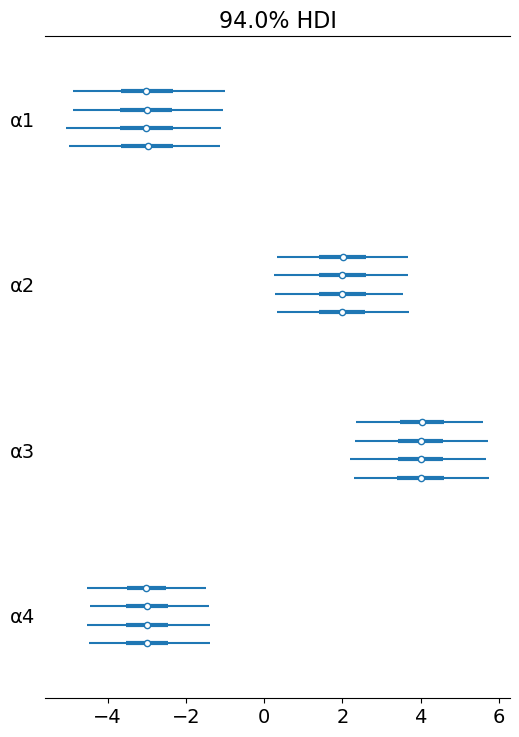

In [5]:
az.plot_forest(trace, var_names=["α1", "α2", "α3", "α4"])

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

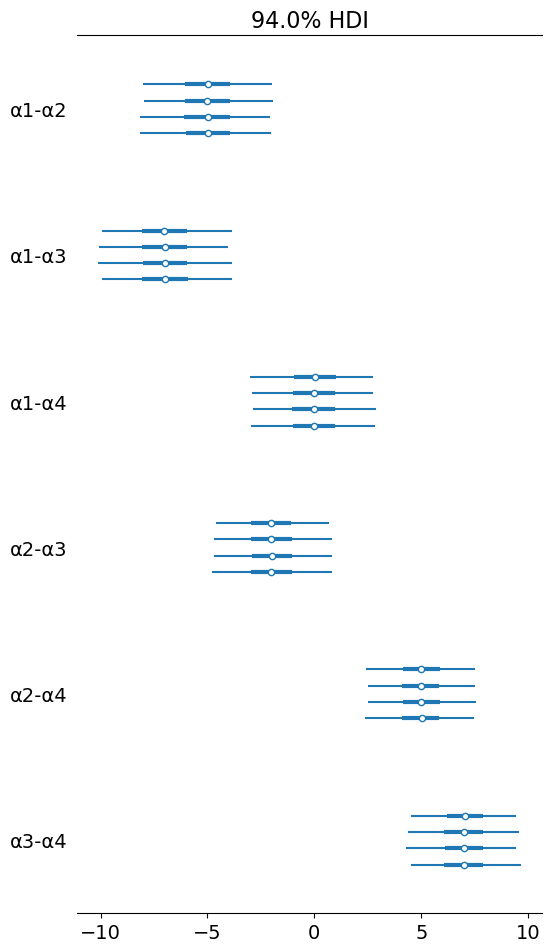

In [6]:
az.plot_forest(trace, var_names=["~τ", "~μ0", "~α1", "~α2", "~α3", "~α4"])

## A more concise method
Not necessarily pretty, but easier to extend to more treatments. I'm interested in seeing other peoples' methods here; I feel like this could still be a lot cleaner.

In [7]:
# get possible combinations
combos = list(combinations(range(4), 2))
combos

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

In [8]:
with pm.Model() as m:
    mu0 = pm.Normal("μ0", mu=0, tau=0.0001)
    tau = pm.Gamma("τ", 0.001, 0.001)

    alphas = [pm.Normal(f"α{i}", mu=0, tau=0.0001) for i in range(2, 5)]

    # sum-to-zero constraint
    alphas.insert(0, pm.Deterministic("α1", -(alphas[0] + alphas[1] + alphas[2])))

    mus = [
        pm.Deterministic(f"mu{i + 1}", mu0 + alpha) for i, alpha in enumerate(alphas)
    ]

    likelihoods = [
        pm.Normal(f"lik{i + 1}", mu=mus[i], tau=tau, observed=data[i + 1])
        for i, mu in enumerate(mus)
    ]

    [pm.Deterministic(f"α{i + 1} - α{j + 1}", alphas[i] - alphas[j]) for i, j in combos]

    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ0, τ, α2, α3, α4]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 27 seconds.


In [9]:
az.summary(trace, var_names=["α"], filter_vars="like", kind="stats")

,mean,sd,hdi_3%,hdi_97%
α2,1.993,0.893,0.262,3.612
α3,4.002,0.887,2.364,5.706
α4,-3.000,0.822,-4.540,-1.431
α1,-2.995,1.040,-4.914,-0.979
α1 - α2,-4.988,1.627,-8.166,-2.008
α1 - α3,-6.997,1.627,-9.994,-3.866
α1 - α4,0.005,1.541,-2.954,2.839
α2 - α3,-2.009,1.424,-4.701,0.701
α2 - α4,4.993,1.363,2.390,7.527
α3 - α4,7.002,1.348,4.442,9.526


In [10]:
%watermark -n -u -v -iv -p aesara,aeppl

Last updated: Fri Feb 03 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.9.0

aesara: 2.8.10
aeppl : 0.1.1

numpy: 1.24.1
pymc : 5.0.1
arviz: 0.14.0

